In [219]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, math, pdb, glob, time, fnmatch, datetime
from astropy.table import Table, vstack, hstack, Column, unique, join
from astroquery.ipac.ned import Ned
import astropy.units as u
from astropy import coordinates

def stop(): pdb.set_trace()

cat=Table.read('CatVisClass_AmberW_20220802.fits')

cat = cat[np.where((cat['maxcsig'] >= 8) & (cat['candfilt'] > 0))]
# print(cat['objid','ra','dec', 'galb', 'maxcsig', 'zphot', 'zphoterr','visclass1'])


### Calculate percent contamination across all detections

In [220]:
cat_star = cat[np.where((cat['visclass1'] == 2) | (cat['visclass1'] == 4))]
cat_junk = cat[np.where(cat['visclass1'] == 3)]
cat_gal = cat[np.where((cat['visclass1'] == 1) | (cat['visclass1'] == 5))]

perc_contamination = (len(cat_star) + len(cat_junk)) / len(cat)
print(perc_contamination)


0.5039920159680639


### Scatter plot of all object detections, RA and Dec

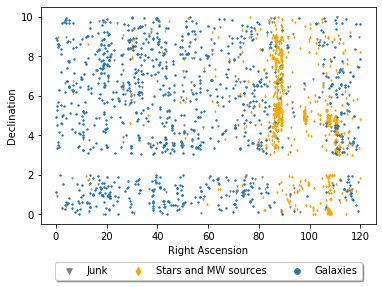

In [221]:
plt.scatter(cat_junk['ra'], cat_junk['dec'], marker='v', color='grey', s=2, label='Junk')
plt.scatter(cat_star['ra'], cat_star['dec'], marker='d', color='orange', s=2, label='Stars and MW sources')
plt.scatter(cat_gal['ra'], cat_gal['dec'], marker='o', s=2, label='Galaxies')

plt.xlabel("Right Ascension")
plt.ylabel("Declination")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5, markerscale=4)

plt.savefig('plots/star_field.jpg', dpi=600, bbox_inches='tight')

### Bin data from 0 to 65 absolute galactic latitude for percent contamination

In [222]:
bins = []
for i in range(0, 65, 5):
    cat_bin = cat[np.where((abs(cat['galb']) >= i) & (abs(cat['galb']) < i + 5))]
    perc = [len(cat_bin[np.where(cat_bin['visclass1'] == x)]) / len(cat_bin) if len(cat_bin) else 0 for x in range(1, 6)]
    bins.append(perc)

### Plot binned data for percent contamination

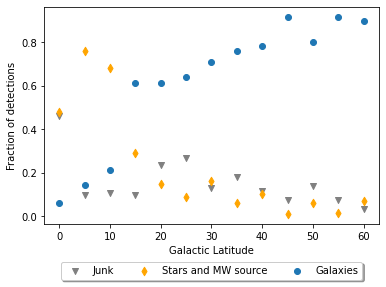

In [223]:
bins_gal = [i[0] for i in bins]
bins_star = [i[1] for i in bins]
bins_junk = [i[2] for i in bins]
bins_mw = [i[3] for i in bins]
bins_pog = [i[4] for i in bins]
bins_good = [i[0] + i[4] for i in bins]
bins_bad = [i[2] + i[3] for i in bins]
label_x = [i for i in range(0, 65, 5)]

plt.scatter(label_x, bins_bad, marker="v", color='grey', label='Junk')
plt.scatter(label_x, bins_star, marker="d", color="orange", label='Stars and MW source')
plt.scatter(label_x, bins_good, marker="o", label='Galaxies')

plt.xlabel("Galactic Latitude")
plt.ylabel("Fraction of detections")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)

plt.savefig('plots/binned_fraction.jpg', dpi=600, bbox_inches='tight')

### Query NED to cross-match redshifts and find the number of new objects detected

In [224]:
new_count = 0
known_count = 0
new_id = []
known_redshifts = []

for obj in cat_gal:
    cclu = coordinates.SkyCoord(ra=obj['ra']*u.deg, dec=obj['dec']*u.deg)
    result_table = Ned.query_region(cclu, radius=4. * u.arcsec)
    if (len(result_table) == 0) or (result_table[0]['Redshift Points'] == 0):
        new_count += 1
        new_id.append(obj['objid'])
    else:
        known_count += 1
        known_redshifts.append(result_table[0]['Redshift'])

print(new_count)
print(known_count)

# cclu = coordinates.SkyCoord(ra=4.05959244523772*u.deg, dec=0.414876956198093*u.deg)
# result_table = Ned.query_region(cclu, radius=4. * u.arcsec)
# print(result_table.colnames)

511
483


### Plot histogram of known redshifts

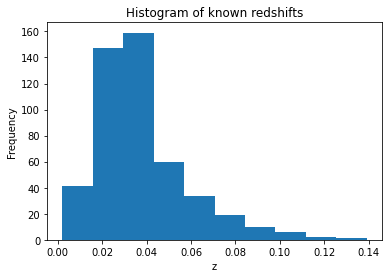

In [225]:
redshifts = [z for z in known_redshifts if z <= 0.175]
plt.hist(redshifts, bins=10)

plt.title("Histogram of known redshifts")
plt.xlabel("z")
plt.ylabel("Frequency")

plt.savefig('plots/z_hist.jpg', dpi=600, bbox_inches='tight')


In [226]:
# plots
# binned fraction of different visclasses per galb
# ex: fraction of star detections per all detections per galb interval
# scatter/bar graph showing percentage of different detections per galb interval
# visualization of a patch of the sky; different symbols/colors for stars or galaxies
# histogram of maxcsig
# get labeled cutouts of the most extreme objects(top 10% maxcsig) into a collage
# identify how many detections are new (astroquery, cross-match against NED's known redshifts)
# two results: methodology and science; methodology = classification statistics; science = interesting, real galaxies (extreme objects)
# methodology: table of total number of candidates and how those break down into various statistics for each object class
# understand how that is distributed across the sky
# dec vs ra colorcoded classifications
# histogram/scatter of contaminations vs galb
# first motivation slide: show localizations of ligo wave events; we need to find galaxies to increase the efficiency of searches for them
# how do we find new galaxies? -> CLU survey
# we need human visual classification to sort out the stars and junk
# how i did classifications(examples, screenshots)
# statistics and plots
# science results: number of new objects and number of new extreme objects